# Testing the Word Embedding Analogy: "King" - "Man" + "Woman" = "Queen"
Word embeddings are often praised for their remarkable property: performing arithmetic operations on word vectors can yield a resulting vector that closely resembles a word whose meaning semantically and logically aligns with the equation.

A common example is:
_**King - Man + Woman ~ Queen**_

This notebook will test this feature on a handful of word embeddings.

## Key Findings
- For every test, the closest vector to "King" - "Man" + "Woman" was "King", however "Queen" was a close second

More info:
- https://kawine.github.io/blog/nlp/2019/06/21/word-analogies.html
- https://aclanthology.org/C16-1332.pdf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap

from sklearn.metrics.pairwise import cosine_similarity

random_state=42

## With transformers

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_word_embedding(word):
    # Get the embeddings for a given word
    
    # Tokenize
    inputs = tokenizer(word, return_tensors="pt")
    
    # Get the model's output (the embeddings for the word)
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the last hidden state (token embeddings)
    # We will use the mean of all token embeddings for the word (e.g., for multi-token words)
    last_hidden_state = outputs.last_hidden_state
    word_embedding = last_hidden_state.mean(dim=1).squeeze().numpy()
    return word_embedding

# Get embeddings for words. Some are related, others arent.
words = ["king", "man", "queen", "chair", "horse", "computer", "poetry", "woman", "apple", "royalty", "prince", "princess"]
word_embeddings = np.array([get_word_embedding(word) for word in words])
print("Embedding vectors have", word_embeddings[0].shape[0], "dimensions")

# Add a new vector king - man + woman to see where it lands
king_man_woman = word_embeddings[words.index("king")] - word_embeddings[words.index("man")] + word_embeddings[words.index("woman")]
words.append("king - man + woman")
word_embeddings = np.vstack([word_embeddings, king_man_woman])

Embedding vectors have 768 dimensions


## Reduce dim and visualize

C:\Users\Garrett Michael\projects\Word-Embedding-Analogies\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Garrett Michael\projects\Word-Embedding-Analogies\venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2D embedding for  king [8.62485  7.188048]
2D embedding for  man [7.8733373 7.444513 ]
2D embedding for  queen [8.945732 6.663493]
2D embedding for  chair [9.309523  5.9036074]
2D embedding for  horse [7.2599006 6.607966 ]
2D embedding for  computer [8.333528 5.800518]
2D embedding for  poetry [7.436025 5.888065]
2D embedding for  woman [7.188187 7.338295]
2D embedding for  apple [8.168461 5.203801]
2D embedding for  royalty [8.936441  5.2374587]
2D embedding for  prince [9.721509 6.669891]
2D embedding for  princess [8.145061 6.590362]
2D embedding for  king - man + woman [9.203793 7.574013]


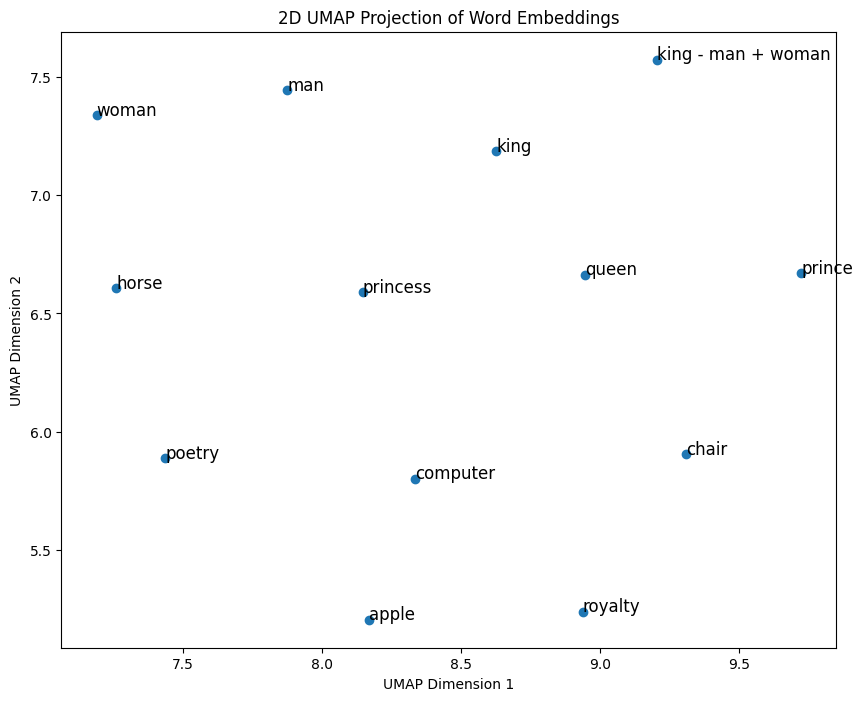

In [3]:
# Use UMAP to reduce the dimensionality to 2
umap_model = umap.UMAP(
    n_neighbors=30,
    n_components=2,
    random_state=42,
    metric = 'cosine')
umap_embeddings = umap_model.fit_transform(word_embeddings)

for i, word in enumerate(words):
    print("2D embedding for ", word, umap_embeddings[i])

# Plot the reduced embeddings for visualization
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], marker='o')

# Annotate each point with the corresponding word
for i, word in enumerate(words):
    plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=12)

plt.title('2D UMAP Projection of Word Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

### Get a list of most similiar
The above chart groups words in a somewhat logical way (all royal terms in the same area), but it's not as close as I would've thought. Lets see a list of n closest values

In [5]:
# Get the vocabulary of the model. Compare to find the most common word.
vocab = list(tokenizer.get_vocab().keys()) 
vocab_embeddings = []
print("length of vocab", len(vocab))

for word in vocab:
    word_embedding = get_word_embedding(word)
    vocab_embeddings.append(word_embedding)

vocab_embeddings = np.array(vocab_embeddings)

# Compute cosine similarities between the result of "king" - "man" + "queen" and each word in the vocabulary
cos_similarities = cosine_similarity([king_man_woman], vocab_embeddings)

# Find the index of the most similar word
most_similar_index = np.argmax(cos_similarities)

# Get the most similar word
most_similar_word = vocab[most_similar_index]

print(f"The word most similar to 'king' - 'man' + 'queen' is: {most_similar_word}")

# Get the top N most similar words
top_n = 10
top_n_indices = np.argsort(cos_similarities[0])[::-1][:top_n]  # Sort by similarity in descending order
top_n_similar_words = [(vocab[i], cos_similarities[0][i]) for i in top_n_indices]

# Print the top N similar words with their cosine similarity
for word, similarity in top_n_similar_words:
    print(f"{word}: {similarity:.4f}")

The word most similar to 'king' - 'man' + 'queen' is: king
king: 0.9248
throne: 0.8653
queen: 0.8644
monarch: 0.8642
princess: 0.8620
prince: 0.8615
woman: 0.8611
spouse: 0.8584
servant: 0.8546
guards: 0.8470


## With Gensim

In [7]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model (e.g., 'word2vec-google-news-300')
model = api.load("word2vec-google-news-300")

# Get embeddings for words. Some are related, others arent.
words = ["king", "man", "queen", "chair", "horse", "computer", "poetry", "woman", "apple", "royalty", "prince", "princess"]
word_embeddings = np.array([model[word] for word in words])
print("Embedding vectors have", word_embeddings[0].shape[0], "dimensions")

# Add a new vector king - man + woman to see where it lands
king_man_woman = word_embeddings[words.index("king")] - word_embeddings[words.index("man")] + word_embeddings[words.index("woman")]
words.append("king - man + woman")
word_embeddings = np.vstack([word_embeddings, king_man_woman])

Embedding vectors have 300 dimensions


### Reduce the dimensions to visualize

2D embedding for  king [-5.134401   1.0353686]
2D embedding for  man [-3.2198458  1.8672913]
2D embedding for  queen [-4.4649215  1.046492 ]
2D embedding for  chair [-3.9092903  1.3560694]
2D embedding for  horse [-2.7151172  1.5589519]
2D embedding for  computer [-2.9202545  0.4757991]
2D embedding for  poetry [-3.7865517   0.35780287]
2D embedding for  woman [-3.576207   2.4458113]
2D embedding for  apple [-2.3635273  0.8375894]
2D embedding for  royalty [-5.0842075   0.29994875]
2D embedding for  prince [-5.18779    1.8354126]
2D embedding for  princess [-4.407302   -0.04949602]
2D embedding for  king - man + woman [-4.446396   1.7688885]


C:\Users\Garrett Michael\projects\Word-Embedding-Analogies\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Garrett Michael\projects\Word-Embedding-Analogies\venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


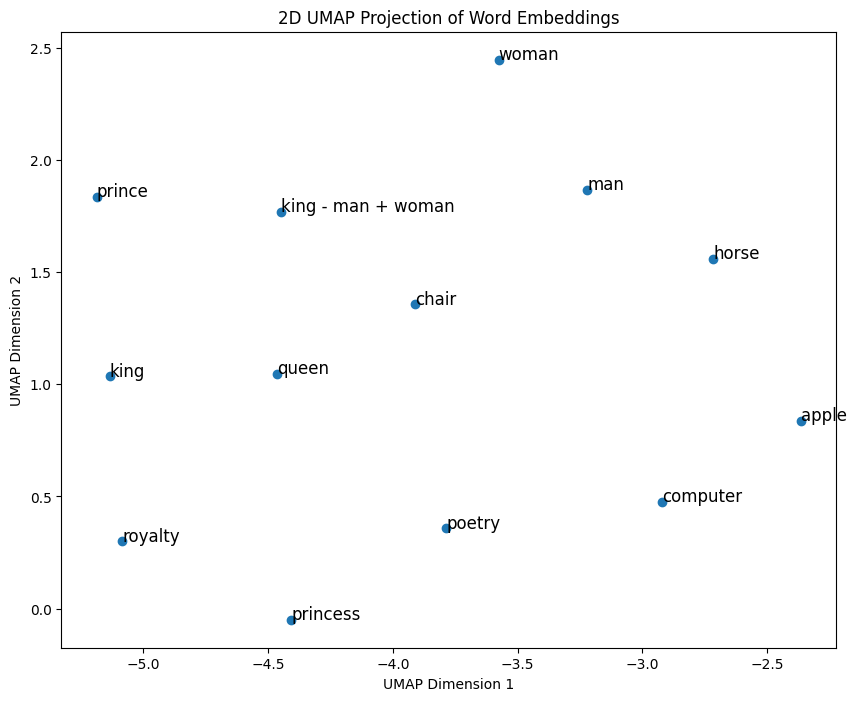

In [8]:
# Use UMAP to reduce the dimensionality to 2
umap_model = umap.UMAP(
    n_neighbors=30,
    n_components=2,
    random_state=42,
    metric = 'cosine')
umap_embeddings = umap_model.fit_transform(word_embeddings)

for i, word in enumerate(words):
    print("2D embedding for ", word, umap_embeddings[i])

# Plot the reduced embeddings for visualization
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], marker='o')

# Annotate each point with the corresponding word
for i, word in enumerate(words):
    plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=12)

plt.title('2D UMAP Projection of Word Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

### Get a list of most similiar
The above chart groups words in a somewhat logical way (all royal terms in the same area), but it's not as close as I would've thought. Lets see a list of n closest values

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

king_man_woman_vec = word_embeddings[-1]

# Get the full vocabulary of the model
vocab = list(model.key_to_index.keys())

# Extract the embeddings for all words in the vocabulary
vocab_embeddings = np.array([model[word] for word in vocab])

# Compute cosine similarity between the "king" - "man" + "woman" vector and all the vocab embeddings
cos_similarities = cosine_similarity([king_man_woman_vec], vocab_embeddings)

# Get the top N most similar words
top_n = 10
top_n_indices = np.argsort(cos_similarities[0])[::-1][:top_n]  # Sort by similarity in descending order
top_n_similar_words = [(vocab[i], cos_similarities[0][i]) for i in top_n_indices]

# Print the top N similar words with their cosine similarity
for word, similarity in top_n_similar_words:
    print(f"{word}: {similarity:.4f}")

king: 0.8449
queen: 0.7301
monarch: 0.6455
princess: 0.6156
crown_prince: 0.5819
prince: 0.5777
kings: 0.5614
sultan: 0.5377
Queen_Consort: 0.5344
queens: 0.5290
